In [1]:
### Exploratory data Analysis 
# Initial Cleaning

In [3]:
import pandas as pd
from pathlib import Path

path = Path.cwd().parent / 'data' / 'bronze' / 'creditcard.csv'
df = pd.read_csv(path)
df.head(3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
# Checking for nulls
df.isnull().sum()

In [ ]:
# checking for duplicate entries
df.duplicated().sum()

In [ ]:
# Let's see these duplicates
df[df.duplicated()]

In [4]:
# Cleaning the dataset for duplicates
print(f'df shape before removing duplicates: {df.shape}')
print('removing duplicates...')
# Noted: the 'duplicates' that pandas finds and drops are exact duplicates, the first intance is 
# the default to be kept in the dataset
df_cleaned = df.drop_duplicates()
print(f'removed rows: {df_cleaned.shape[0]-df_cleaned.shape[0]} ; shape after removal: {df_cleaned.shape}')

df shape before removing duplicates: (284807, 31)
removing duplicates...
removed rows: 0 ; shape after removal: (283726, 31)


In [ ]:
# checking info()
df_cleaned.info()

In [ ]:
# lets analyze the class column by first checking the imbalance in the Class column
df_cleaned.value_counts("Class")

<AxesSubplot: ylabel='count'>

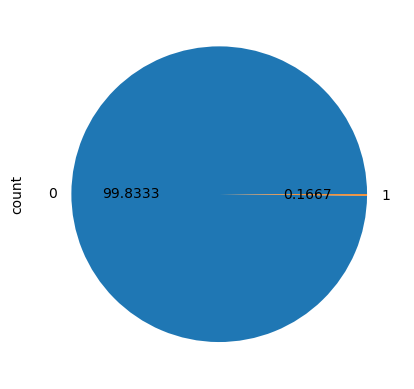

In [7]:
#plotting to see the fraud class imbalance in a piechart
fraud_class = df_cleaned.Class
fraud_class.value_counts().plot.pie(autopct="%.4f")

In [ ]:
#plotting to see the fraud class imbalance in a barplot
fraud_class.value_counts().plot.bar()

In [ ]:
# noting the percentile proportion
fraud_class.value_counts() / fraud_class.shape[0] * 100

In [ ]:
# continuing initial analysis
df_cleaned.describe()

In [ ]:
# the minimum for amount is zero, these 0 amount transactions are sometimes used to test cards to verify validity. see: https://solidgate.com/glossary/zero-value-authorization/
# lets analyze how many of these zero value avaliations where actually frauds or not
df_cleaned[df_cleaned['Amount'] == 0]['Class'].value_counts()

In [ ]:
# max time in seconds: 172792/3600 = 47.997 hours. Coresponds with the two days worth of transaction data
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title('Percentage of transactions amount')
amount_percentage_histplot = sns.histplot(data=df_cleaned, x='Amount', binwidth=50,binrange=(0,1000),stat='percent')

for patch in amount_percentage_histplot.patches:
    height = patch.get_height()
    if height > 0:
        amount_percentage_histplot.annotate(f'{height:.1f}%',  # format as percentages
            (patch.get_x() + patch.get_width() / 2, height), # setting each coordinate to be on the patch
            ha='center', va='bottom', fontsize=8, rotation=0) # position related to the patch cordinate, right above and center

plt.tight_layout()

plt.show() # Graph discussion still needed after this as md talking about how almost 70$ of all transactions are bellow 50%

### Feature Engineering for Exploration: Creating `Amount_log`

During the exploratory data analysis (EDA), we observed that the `Amount` feature shows a **strong positive skew**, with most transactions being low-value and a small number of very high-value outliers.

To better visualize and analyze this distribution, we applied a **logarithmic transformation**, creating a new column called `Amount_log`. This transformation helps:

- Reduce the impact of extreme outliers
- Make the distribution more normal-like
- Allow for clearer visualization in boxplots and other graphs
- Provide better interpretability for class comparisons (fraud vs non-fraud)

---

**Important Note:**  
This feature (`Amount_log`) was created **only for EDA and visualization purposes**.  
It will **not be included in the Silver data layer**, in accordance with good data lake practices.

> All formal feature engineering steps (including this log transformation, if we choose to use it for modeling after later testing) **will be implemented inside the ML pipeline (`/src/ml_pipeline.py`)** when building our modeling dataset (Gold layer).



In [ ]:
# Amount varies a lot, lets look more into that and see if any of the outliers are frauds
# df.loc[:,"Amount":"Class"].sort_values(by='Amount', ascending=False)
# There are a couple of outliers, namely this 25000
# However the first fraud only shows up at Amount 2125.87, so this high variance shouldnt affect the model later
import numpy as np


# log-scaling in order to properly see the data that would be obscured by the outliers
df_cleaned['Amount_log'] = np.log(df_cleaned['Amount'] + 1)
sns.boxplot(data = df_cleaned, x='Amount_log',y='Class', orient='h')

As expected, since there is a lot less data about the fraud transactions, it is more spread out
Noticibly it's values are generally lower, indicating most fraud transactions tend to have smaller, more common amounts. Although we can see the maximums and minimums roughly align with regular transactions.

In [ ]:
#correlation between features -> very usefull later in machine learning process for feature engineering and dropping

corr = df_cleaned.corr()
sns.heatmap(corr)
plt.show()

In [ ]:
# Too many features! lets see the correlation only with our target Class, for better understanding
Top_corr = df_cleaned.corr()['Class'].drop('Class').abs().sort_values(ascending=False)
print(Top_corr)


In [ ]:
# given the one-dimensionality of the correlation, here is a barplot showing the most and least absolutely correlated
# features 

plt.figure(figsize=(12,6))
sns.barplot(Top_corr)
plt.title("Features correlated to fraud (absolute value)")
plt.show()

WIP: here there should be a markdown talking about the graph, btw all the graphs need title and captions so those should be added

In [ ]:
# What changes between non-fraudulent and fraudulent
df_cleaned.groupby('Class').median() # median used beacause it reflects better the log-transformed Amount

### File Format Decisions Across Data Layers

Given that the original dataset from Kaggle was provided in CSV format, we chose to **keep the raw CSV file in the Bronze layer**, in line with data lake best practices of preserving source data in its native, raw format.

Starting from the Silver layer onward, we converted the data to **Parquet format**, which offers:

- Better compression
- Faster read/write speeds
- More efficient downstream processing for ML and dashboard tasks

This design choice aligns with the Medallion Architecture principle of using **Bronze for raw input preservation** and **Parquet for optimized internal layers**.


In [ ]:
# Loading cleaned data into the silver layer as parquet
from pathlib import Path

project_root = Path.cwd().parent 
output_path = project_root / 'data' / 'silver' / 'creditcard_fraud_cleaned.parquet'

df_cleaned.drop("Amount_log", axis=1)
df_cleaned.to_parquet(output_path, index=False,engine="pyarrow")


### Column Naming Convention

As part of our Silver layer cleaning final pipeline, we standardized all column names to snake_case.  
This helps ensure naming consistency across all layers (Silver, Gold, and Diamond) and reduces risks of errors during downstream ML processing.

---

### Handling Missing Values (Nulls)

Although our EDA confirmed that there are no missing values in the dataset,  
we retained a defensive null-removal step in the Silver data cleaning pipeline.  
This ensures that future pipeline runs remain robust even if upstream data sources change.
